### Imports

In [454]:
# !pip install --user seaborn

In [455]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [456]:
import torch
torch.cuda.is_available()

True

### Load data

In [457]:
new_gapn_data_file = "20211018-GapN-data-up-to-SM160.csv"
data = pd.read_csv(new_gapn_data_file, index_col=0)
# data = data.dropna()
# drop the barcode of the sequences: MGSSHHHHHHSSGLVPRGSH
data['Sequence'] = data['Sequence'].apply(lambda x: x.replace('MGSSHHHHHHSSGLVPRGSH', '').strip('*'))
data.index = data.index.str.strip('p')

#### Make sure sequences match mutation annotation 

In [458]:
seq_list = data.Sequence.apply(list).apply(np.asarray)
mutations = seq_list.apply(lambda x: [f"{seq_list[0][i]}{i}{x[i]}" for i in np.where(seq_list[0] != x)[0]])
data['mutation_from_seq'] = mutations.apply(set)
data['mutation_from_annot'] = data.WT_mutations.fillna('').str.split(' \+ ')\
    .apply(lambda x: [xi.strip().rstrip() for xi in x]).apply(set)

data[data.mutation_from_seq != data.mutation_from_annot].iloc[:, -2:]

,mutation_from_seq,mutation_from_annot
WT,{},{}


### Calculate Embeddings

In [459]:
import sys
sys.path.append('~/Packages/esm')

import esm

#### Load model

In [460]:
torch.hub.set_dir('/tmp/.cache/torch')
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1v_t33_650M_UR90S_1")

Using cache found in /tmp/.cache/torch/facebookresearch_esm_main
/tmp/.cache/torch/facebookresearch_esm_main/esm/pretrained.py:148: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [461]:
data.head()

,Sequence,WT_mutations,NAD+_initial_rate,NADP+_initial_rate,mutation_from_seq,mutation_from_annot
WT,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,NaN,0.17667,41.342222,{},{}
SM038,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,G209V,0.80667,39.055556,{G209V},{G209V}
SM050,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,K176F + S210E,-0.00333,1.566667,"{S210E, K176F}","{S210E, K176F}"
SM051,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,K176F + T179E,0.02000,0.113333,"{T179E, K176F}","{T179E, K176F}"
SM052,MTKQYKNYVNGEWKLSENEIKIYEPASGAELGSVPAMSTEEVDYVY...,T179F + G209E + S210E,0.01333,0.006667,"{T179F, G209E, S210E}","{T179F, G209E, S210E}"


In [462]:
batch_converter = alphabet.get_batch_converter()
batch_labels, batch_strs, batch_tokens = batch_converter(list(data['Sequence'].items()))
batch_dataloader = torch.utils.data.DataLoader(batch_tokens, batch_size=8)

# Extra

In [463]:
from tqdm.auto import tqdm, trange

In [464]:
def calculate_likelihood(i):
    
    model, alphabet = esm.pretrained.load_model_and_alphabet(f'/projects/deepgreen/pstjohn/esm_models/esm1v_t33_650M_UR90S_{i}.pt')

    batch_converter = alphabet.get_batch_converter()
    batch_labels, batch_strs, batch_tokens = batch_converter(list(data['Sequence'].items()))
    batch_dataloader = torch.utils.data.DataLoader(batch_tokens, batch_size=8)

    if torch.cuda.is_available():
        model = model.cuda()

    output = []
    with torch.no_grad():
        for batch in tqdm(batch_dataloader, leave=False):
            batch_cuda = batch.cuda()
            token_probs = torch.log_softmax(model(batch_cuda)['logits'], dim=-1)
            gathered_probs = torch.gather(token_probs.cpu(), 2, batch.unsqueeze(-1)).squeeze()
            output.append(gathered_probs.cpu().numpy())

    output = np.concatenate(output)
    
    return output

In [465]:
outputs = np.array([calculate_likelihood(i) for i in trange(1, 6)])

/tmp/.cache/torch/facebookresearch_esm_main/esm/pretrained.py:148: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


<AxesSubplot:>

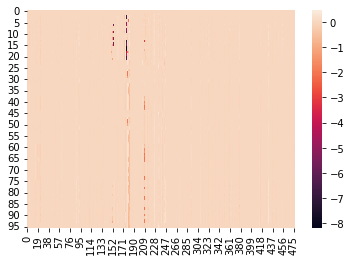

In [466]:
normed_likelihood = (outputs - outputs[:, [0], :])
sns.heatmap(normed_likelihood.mean(0))

In [467]:
data['mutation'] = data.mutation_from_annot.apply(list)
data_explode = data.explode('mutation')

In [468]:
mutation_counts = data_explode.mutation.value_counts().drop('')
data_subset = data_explode[data_explode.mutation.isin(mutation_counts[mutation_counts >= 1].index)]

In [469]:
lh = pd.DataFrame(normed_likelihood.sum(2).mean(0), index=data.index, columns=['value'])
lh['mutation'] = data['mutation']
lh_explode = lh.explode('mutation')

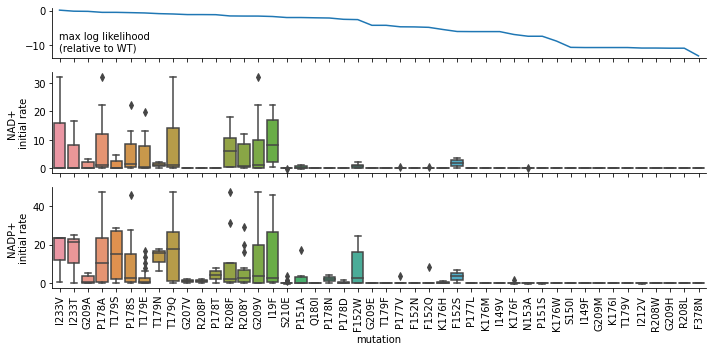

In [470]:
fig, axs = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 2, 2]}, sharex=True, figsize=(10, 5))

# x_order = data_subset.groupby('mutation').max().sort_values('NAD+_initial_rate', ascending=False).index
x_order = lh_explode.groupby('mutation').value.max().sort_values(ascending=False).drop('').index

sns.boxplot(data=data_explode, x='mutation', y='NAD+_initial_rate',
            order=x_order, ax=axs[1])

sns.boxplot(data=data_explode, x='mutation', y='NADP+_initial_rate',
            order=x_order, ax=axs[2])

axs[1].set_ylabel('NAD+\ninitial rate')
axs[2].set_ylabel('NADP+\ninitial rate')

axs[0].plot(np.arange(len(x_order)), lh_explode.groupby('mutation').value.max().reindex(x_order).values.squeeze())
axs[0].text(0.01, 0.1, 'max log likelihood\n(relative to WT)', ha='left', va='bottom', transform=axs[0].transAxes)

axs[1].set_xlabel(None)

_ = axs[-1].set_xticklabels(axs[-1].get_xticklabels(), rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig('esm1v_vs_activity.svg')

In [471]:
data['log_likelihood'] = normed_likelihood.sum(2).mean(0)

Text(0, 0.5, 'initial rate')

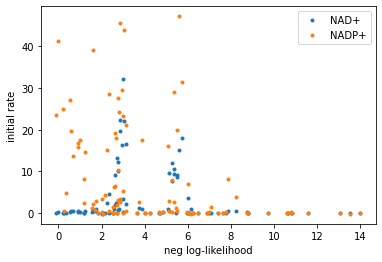

In [483]:
plt.plot(-data.log_likelihood, data['NAD+_initial_rate'], '.', label='NAD+')
plt.plot(-data.log_likelihood, data['NADP+_initial_rate'], '.', label='NADP+')
plt.legend(loc='upper right')
plt.xlabel('neg log-likelihood')
plt.ylabel('initial rate')